# The data
---

In [28]:
# Reading our data
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("Length of text: {} characters".format(len(text)))

Length of text: 1115394 characters


In [29]:
# Let's look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [30]:
# Let's create our vocabulary, based on our data
chars = sorted(list(set(text))) # set() removes duplicates
vocab_size = len(chars) # We will call it C, from Channel
print("Number of unique characters: {}".format(vocab_size))
print(''.join(chars))

Number of unique characters: 65

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [31]:
# Now we need to tokenize our text
char2idx = {u:i for i, u in enumerate(chars)}
idx2char = {i:u for i, u in enumerate(chars)}

# Here we create two functions to encode and decode our text
tokenize = lambda text: [char2idx[c] for c in text] # encode text to numbers
detokenize = lambda indexes: ''.join([idx2char[c] for c in indexes]) # decode indexes to text

# Let's try it
ec = tokenize(text[:13])
dc = detokenize(ec)
print(ec)
print(dc)

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52]
First Citizen


In [32]:
# Let's tokenize our entire text and pass it to a Tensor
import torch
data = torch.tensor(tokenize(text), dtype=torch.long)
print('Shape of data: {}'.format(data.shape))
print(data[:13])

Shape of data: torch.Size([1115394])
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52])


In [33]:
# Let's split the data into train and test sets
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
print('Shape of train_data: {}'.format(train_data.shape))
print('Shape of test_data: {}'.format(val_data.shape))

Shape of train_data: torch.Size([1003854])
Shape of test_data: torch.Size([111540])


# Sampling and Batching the data
---

In [34]:
# We can't feed all the data directly to our model
# In fact, we will train our model with chunks (or blocks) of data
# Each block of data has a maximum length, that we can choose

block_size = 8
print(train_data[:block_size+1], end='\n---\n\n')

# In a single block, we have multiple examples to train our model,
# because all this characters follow each other. For example:

x = train_data[:block_size]
y = train_data[1:block_size+1] # y is the next character after x (what we want to predict)

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print('Context: {} -> Target: {}'.format(context, target))

# So the role of our model is to predict the next character, given a context.
# Note that the context is truncated at a maximum length (block_size)!

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])
---

Context: tensor([18]) -> Target: 47
Context: tensor([18, 47]) -> Target: 56
Context: tensor([18, 47, 56]) -> Target: 57
Context: tensor([18, 47, 56, 57]) -> Target: 58
Context: tensor([18, 47, 56, 57, 58]) -> Target: 1
Context: tensor([18, 47, 56, 57, 58,  1]) -> Target: 15
Context: tensor([18, 47, 56, 57, 58,  1, 15]) -> Target: 47
Context: tensor([18, 47, 56, 57, 58,  1, 15, 47]) -> Target: 58


In [35]:
torch.manual_seed(1337)
batch_size = 4 # number of independent blocks (sequences) we will process in parallel
block_size = 8 # maximum context length for predictions

# We define a function to generate a batch of randomly picked blocks from our text
def get_batch(split):
    # Generate a smal batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,)) # random start indices for the examples
    x = torch.stack([data[i:i+block_size] for i in ix]) # (batch_size, block_size)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # targets (the same as inputs, but shifted one character ahead)
    return x, y

xb, yb = get_batch('train')
print('Shape of xb: {} and yb: {}'.format(xb.shape, yb.shape), end='\n\n')
print(xb, end='\n\n')
print(yb)

Shape of xb: torch.Size([4, 8]) and yb: torch.Size([4, 8])

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])

tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


# The Bigram Model
---

In [36]:
# Let's implement the simplest wording embedding possible: a Bigram Model
# We can do this, because in our model the tokens do not talk to each other,
# they are completely independent (there's no context involved).

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        # Each token directly read off the lofigs for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B, T) tensor of integers
        # The logits are the "scores" for the next character in the sequence
        logits = self.token_embedding_table(idx) # (B, T, C)
        
        if targets is None:
            return logits, None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # (B*T, C) => Flatten to pass to nn.CrossEntropyLoss
            targets = targets.view(B*T) # (B*T) => Flatten to pass to nn.CrossEntropyLoss
            loss = F.cross_entropy(logits, targets)
            return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # This is the function we will use to generate new text given a context

        # idx is a (B, T) tensor of integers in the current context
        for _ in range(max_new_tokens):
            logits, loss = self(idx) # Get the predictions
            logits = logits[:,-1,:] # Focus only on the last time step => (B, C)
            probs = F.softmax(logits, dim=-1) # Turn logits into probabilities
            new_tokens = torch.multinomial(probs, num_samples=1) # Sample from the distribution => (B, 1)
            idx = torch.cat([idx, new_tokens], dim=1) # Append the new tokens to the current context => (B, T+1)
        return idx
    
m = BigramLanguageModel(vocab_size)
out, loss = m(xb, yb)
print(out.shape, loss, end='\n\n')

# Let's test the generate function
idx = torch.zeros([1,1], dtype=torch.long) # (B, T) => (1, 1)

# It's reasonable to kick off the generation using 0 as the first token,
# because 0 is the index \n (newline) in our vocabulary

print(detokenize(m.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([32, 65]) tensor(4.8786, grad_fn=<NllLossBackward0>)


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


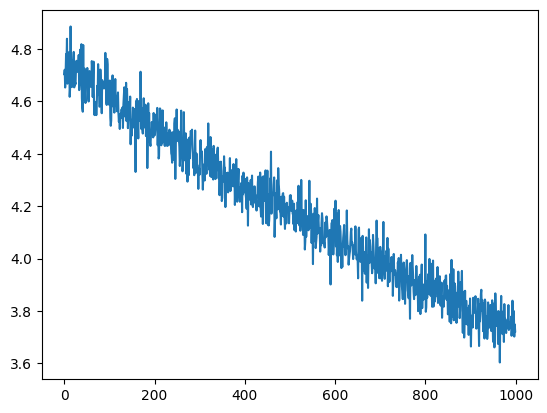

In [37]:
# Let's train this Bigram Model

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

batch_size = 32
losses = []

for steps in range(1000):
    # Get a batch of data
    xb, yb = get_batch('train')
    # Evaluate the loss
    _, loss = m(xb, yb)
    # Reset the gradients
    optimizer.zero_grad(set_to_none=True)
    # Backpropagate the loss
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Save the loss value
    losses.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [38]:
# We start to see we have something more reasonable in the geration!
print(detokenize(m.generate(idx, max_new_tokens=250)[0].tolist()))


olylvLLko'TMyatyIoconxad.?-tNSqYPsx&bF.oiR;BD$dZBMZv'K f bRSmIKptRPly:AUC&$zLK,qUEy&Ay;ZxjKVhmrdagC-bTop-QJe.H?x
JGF&pwst-P sti.hlEsu;w:w a BG:tLhMk,epdhlay'sVzLq--ERwXUzDnq-bn czXxxI&V&Pynnl,s,Ioto!uvixwC-IJXElrgm C-.bcoCPJ
IMphsevhO AL!-K:AIkpre,
r


The Mathematical trick in Self-Attention
---

In [39]:
# Let's consider the following toy example:
import torch
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C) # (B, T, C)

# Given a token location in a sentence, we want the context from its past.
# In a first approach, we can "summarize" its past by averaging all the tokens
# that came before it.

# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t+1, C)
        xbow[b,t] = xprev.mean(dim=0)

print(xbow[0])

# However, due to this nested for loop, this is not very efficient.
# And here we introduce the mathematical trick

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [40]:
# We can compute the cumulative sum of the tokens in the sentence
# using matrix multiplication!
a = torch.tril(torch.ones(3,3)) # (T, T) => Lower triangular matrix
a /= a.sum(dim=-1, keepdim=True) # (T, T) => Normalize the rows so they sum to 1
b = torch.randint(0, 10, (3,2)).float() # (T, C) => Random tokens
c = a @ b # (T, T) @ (T, C) => (T, C) => Cumulative sum of tokens

# Let's see how this works
print(a)
print(b)
print(c)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[8., 6.],
        [5., 2.],
        [4., 4.]])
tensor([[8.0000, 6.0000],
        [6.5000, 4.0000],
        [5.6667, 4.0000]])


In [41]:
# Let's compare the two approaches
wei = torch.tril(torch.ones((T,T))) # (T,T) -> Lower triangular matrix
wei /= wei.sum(dim=-1, keepdim=True) # (T,T) -> Normalize the rows so they sum to 1
xbow2 = wei @ x # (T,T) @ (B,T,C) --> "(B,T,T) @ (B,T,C)" --> (B,T,C)
torch.allclose(xbow, xbow2)

True

In [70]:
# We can write this same mask in a more interesting way:
tril = torch.tril(torch.ones((T,T))) # (T,T) -> Lower triangular matrix
wei = torch.tril(torch.zeros(T,T)) # (T,T)
wei = wei.masked_fill(tril==0, value=float('-inf')) # (T,T) -> Masked fill
print(wei)
wei = wei.softmax(dim=-1) # (T,T) -> Softmax: exp + norm by row (each row sums to 1)
print(wei)
# This way we can do weighted agregations of our past elements with matrix multiplication
# We can think this weighted agregation as an affinity

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


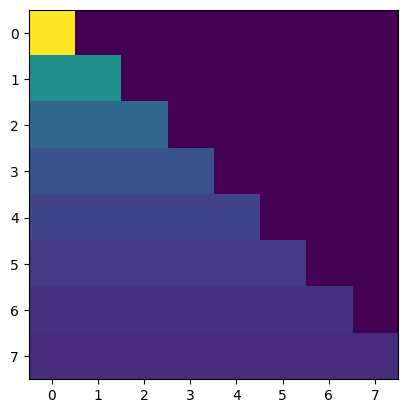

In [71]:
# Let's take a look at the weights
plt.imshow(wei.detach().numpy())

# Self-Attention!
---

In [57]:
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C) # (B, T, C)

In [73]:
# We don't want that tril mask to be uniform, because tokes can talk to other tokens (or nodes) with more
# or less affinity. The way that self attention deals with it, in a data dependent manner, is by creating
# two vectors that are associated to each token:
#  - Query: what the node is looking for
#  - Key: what the node contains
# To get the affinity between the tokens, we take the dot product between the query and the key

# This way, we introduce a new concept that is the Head of the attention:
head_size = 16 # H
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
k = key(x) # (B,T,C) -> (B,T,H)
q = query(x) # (B,T,C) -> (B,T,H)

# No communication between tokens happend yet. We need to compute the affinity between them:
wei = q @ k.transpose(-2,-1) # (B,T,H) @ (B,H,T) -> (B,T,T)
tril = torch.tril(torch.ones((T,T))) # (T,T) -> Lower triangular matrix
wei = wei.masked_fill(tril==0, value=float('-inf')) # (T,T) -> Masking wei (affinity)
wei = F.softmax(wei, dim=-1) # (T,T) -> Log softmax

out = wei @ x # (B,T,T) @ (B,T,C) -> (B,T,C)
out.shape

torch.Size([4, 8, 32])

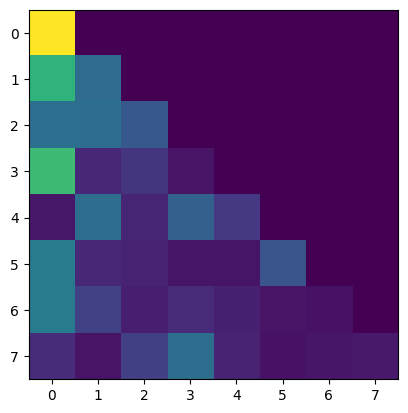

In [74]:
# Let's take a look at the attention weights
plt.imshow(wei[0].detach().numpy())
plt.show()

In [77]:
# There's a last layer complexity in this attantion head, which is the value vector.
# The value vector is the vector that tells us what the node "is going to say".
# We can think of it as a generalization of the "private" form of the raw input vector.

head_size = 16 # H
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B,T,C) -> (B,T,H)
q = query(x) # (B,T,C) -> (B,T,H)
v = value(x) # (B,T,C) -> (B,T,H)

wei = q @ k.transpose(-2,-1) # (B,T,H) @ (B,H,T) -> (B,T,T)
tril = torch.tril(torch.ones((T,T))) # (T,T) -> Lower triangular matrix
wei = wei.masked_fill(tril==0, value=float('-inf')) # (T,T) -> Masking wei (affinity)
wei = F.softmax(wei, dim=-1) # (T,T) -> Log softmax

out = wei @ v # (B,T,T) @ (B,T,H) -> (B,T,H)
out.shape

torch.Size([4, 8, 16])

## Notes
---

* Attention is a **communication mechanism**. We can see it as a graph, where each node communicates with each other that they are allowed, aggregating information with a weighted sum, where these weights are data dependent (can be learned).
* There is no notion of space on the "node pools". This is why we need to encode this information with the positional embedding.
* We can change the way we encode information by changing the mask we are using. We are simply masking the future tokes, because this would give the answer to our model. However, when dealing with sentiment analysis, for example, we could let all the tokes talk to each other in order to ecode the information and obtain a better performance.
* All batches are completely independent (they don't communicate to each other). 
* The reason what we implemented is called *Self-attention* is because the keys, queries and values are coming from the same source vector. There's another mechanism that is called *Cross-attention*, where the keys and queries come from a different pool of nodes, and just the values are generated from our source.

In [88]:
# As a final step, we need to normalize the weights of the attention head.
# We do this by dividing it by the square root of the head size. Why? Because it preserves the variance of the
# weights to one. If you have unit gaussian key and queries, and we do wei naïvely, we will end up with a variance
# ~H. Therefore, if we divide by sqrt(H), the output will have variance 1. We call it Scaled Attention.

k = torch.randn(B,T,16)
q = torch.randn(B,T,16)
print(q.var(), k.var(), end='\n\n')

print('Var without norm: {}'.format((q @ k.transpose(-1,-2)).var(), end='\n\n')) # No normalization
print('Var with norm: {}'.format(((q @ k.transpose(-1,-2))*head_size**-0.5).var())) # Normalization

tensor(1.0296) tensor(0.9528)

Var without norm: 14.973930358886719
Var with norm: 0.9358706474304199
